In [ ]:
!$PATH

In [16]:
import numpy as np
import glob, os, json
import pickle

import matplotlib.pyplot as plt
import corner
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import multiprocessing as mp

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
import time
import scipy
import scipy.integrate as spint

from corner import corner

from astropy.time import Time
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize


from enterprise.pulsar import Pulsar

from la_forge.core import Core
from la_forge.diagnostics import plot_chains

nano11_pkl = '/home/nima/nanograv/11yr_factlike/NANOGrav_11yr_DE436.pickle'
with open(nano11_pkl, 'rb') as f:
    allpsrs=pickle.load(f)

In [2]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    #golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    golden_mean= 0.3333
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        #'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        'figure.figsize': figsize(0.98)}

plt.rcParams.update(params)

/home/nima/anaconda3/envs/nano15/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [7]:
chartdir= '/home/nima/nanograv/11yr_factlike/ULvT_charts_ignore_epoch/'
charts=sorted(os.listdir(chartdir))[:-2]
print(len(charts))
print("expected {} charts".format(48*8))

print(charts)

384
expected 384 charts
['0_0.txt', '0_1.txt', '0_2.txt', '0_3.txt', '0_4.txt', '0_5.txt', '0_6.txt', '0_7.txt', '10_0.txt', '10_1.txt', '10_2.txt', '10_3.txt', '10_4.txt', '10_5.txt', '10_6.txt', '10_7.txt', '11_0.txt', '11_1.txt', '11_2.txt', '11_3.txt', '11_4.txt', '11_5.txt', '11_6.txt', '11_7.txt', '12_0.txt', '12_1.txt', '12_2.txt', '12_3.txt', '12_4.txt', '12_5.txt', '12_6.txt', '12_7.txt', '13_0.txt', '13_1.txt', '13_2.txt', '13_3.txt', '13_4.txt', '13_5.txt', '13_6.txt', '13_7.txt', '14_0.txt', '14_1.txt', '14_2.txt', '14_3.txt', '14_4.txt', '14_5.txt', '14_6.txt', '14_7.txt', '15_0.txt', '15_1.txt', '15_2.txt', '15_3.txt', '15_4.txt', '15_5.txt', '15_6.txt', '15_7.txt', '16_0.txt', '16_1.txt', '16_2.txt', '16_3.txt', '16_4.txt', '16_5.txt', '16_6.txt', '16_7.txt', '17_0.txt', '17_1.txt', '17_2.txt', '17_3.txt', '17_4.txt', '17_5.txt', '17_6.txt', '17_7.txt', '18_0.txt', '18_1.txt', '18_2.txt', '18_3.txt', '18_4.txt', '18_5.txt', '18_6.txt', '18_7.txt', '19_0.txt', '19_1.txt',

In [9]:
skypixs = np.arange(hp.nside2npix(2))
npix = hp.nside2npix(2)
bwm_pols = np.arange(0, np.pi, np.pi/8)
amps = np.linspace(-17,-10,70, endpoint=True)
nano11_Ts = np.linspace(53216.13175403874+180,57387.78760427694-180, 134, endpoint=True)

In [36]:
import random

def compute_ul95(distribution, domain):    
    hires_domain = np.linspace(domain[0], domain[-1], int(len(domain)*100))
    interpolator = scipy.interpolate.interp1d(domain, distribution, kind='cubic')
    hires_integrand = interpolator(hires_domain)
    full_integral = spint.simpson(hires_integrand,x=hires_domain)
    
    domain_idx = 0
    running_integrand = spint.simpson(hires_integrand[domain_idx:domain_idx+2], x=hires_domain[domain_idx:domain_idx+2])
    while running_integrand/full_integral < 0.95:
        domain_idx += 2
        running_integrand = spint.simpson(hires_integrand[0:domain_idx+1], x=hires_domain[0:domain_idx+1])
    
    if spint.simpson(hires_integrand[0:domain_idx],x=hires_domain[0:domain_idx])/full_integral > 0.95:
        return hires_domain[domain_idx-1]
    else:
        return hires_domain[domain_idx]

def sample_hist(weights, centers, num_points=int(1e5), sample_bounds=None, verbose=False):
    #make sure the weights are properly normalized
    #print(weights)
    #print(centers)
    norm = np.sum(weights)
    normed_weights = weights/norm
    #print(normed_weights)
    
    #go through weights and see if there are lower and upper bounds. This will speed up resampling
    
            
            
    #print("lower, upper bounds are: {} and {}\nthe likelihoods between are {}:".format(lower, upper, normed_weights[lower:upper]))    
    
    
    accepted = 0
    
    resampled_chain = []    
    likelihood_interp = scipy.interpolate.interp1d(centers, normed_weights)
    if sample_bounds is None:
        while accepted < num_points:
            amp = random.uniform(centers[0], centers[-1])
            #print("trying amplitude: {}".format(amp))

            likelihood = likelihood_interp(amp)
            #print(likelihood)
            #print("likelihood of amp = {}".format(likelihood))
            if random.random() < likelihood:
                accepted+=1
                if accepted/num_points % 0.02 == 0 and verbose:
                    print("completed {}%".format(accepted/num_points * 100))
                resampled_chain.append(amp)
    else:
        while accepted < num_points:
            amp = random.uniform(sample_bounds[0], sample_bounds[1])
            #print("trying amplitude: {}".format(amp))

            likelihood = likelihood_interp(amp)
            #print(likelihood)
            #print("likelihood of amp = {}".format(likelihood))
            if random.random() < likelihood:
                accepted+=1
                if accepted/num_points % 0.02 == 0 and verbose:
                    print("completed {}%".format(accepted/num_points * 100))
                resampled_chain.append(amp)

        
    #print(sorted(resampled_chain))
    return sorted(resampled_chain)

In [37]:
# Let's make a worker function that does this for a particular epoch and multiprocessify this

def epoch_sample_worker(epoch_idx):
    this_epoch_samples = [] #this should be a list of amplitudes
    outf = '/home/nima/nanograv/11yr_factlike/ULvT_charts_ignore_epoch/epoch_samples/{}.txt'.format(epoch_idx)
    chartdir = '/home/nima/nanograv/11yr_factlike/ULvT_charts_ignore_epoch/'
    for pol_idx, pol in enumerate(bwm_pols):
        for skypix in range(npix):
            chart = np.loadtxt(chartdir + '{}_{}.txt'.format(skypix, pol_idx))
            epoch_max = np.amax(chart[:, epoch_idx])
            
            # we want to get the weights/centers for the amplitudes
            logweights = np.zeros(len(amps))
            for amp_idx in range(len(logweights)):
                like = np.exp(chart[amp_idx, epoch_idx] - epoch_max) 
                logweights[amp_idx] = np.log(like) + epoch_max
                #reweight so that we have uniform priors in the bwm_amplitude
            #plt.close("all")
            #plt.xscale('log')
            #plt.plot(amps, weights)
            #plt.show()
            # Now we need to build weights from logweights
            weights=np.zeros(len(amps))
            
            maxlogweight = np.amax(logweights)
            for logweight_idx, logweight in enumerate(logweights):
                weights[logweight_idx] = 10**amps[logweight_idx] * np.exp(logweight - maxlogweight)
            '''
            plt.close("all")
            plt.xscale('log')
            plt.plot(amps, weights)
            plt.show()
            '''
            
            #now we can resample and add the elements of the chain to this epochs samples.
            sampled = sample_hist(weights, amps, num_points=120, sample_bounds=[-17,-10])


            #now we just want to dump this into this_epoch_samples
            for el in sampled:
                this_epoch_samples.append(el)  
    
    #Now we've resampled this entire time bin for every source location
    #let's just plot some for now
    plt.close("all")
    plt.hist(this_epoch_samples,histtype='step',bins=30 )
    plt.title("Histogram for epoch {}".format(epoch_idx))
    plt.show()
    
    np.savetxt(outf, this_epoch_samples)
    

In [38]:
def ul95_worker(epoch_idx):
    this_epoch_samples = [] #this should be a list of amplitudes
    outf = '/home/nima/nanograv/11yr_factlike/ULvT_charts_ignore_epoch/epoch_samples/{}.txt'.format(epoch_idx)
    chartdir = '/home/nima/nanograv/11yr_factlike/ULvT_charts_ignore_epoch/'
    for pol_idx, pol in enumerate(bwm_pols):
        for skypix in range(npix):
            chart = np.loadtxt(chartdir + '{}_{}.txt'.format(skypix, pol_idx))
            epoch_max = np.amax(chart[:, epoch_idx])
            
            # we want to get the weights/centers for the amplitudes
            logweights = np.zeros(len(amps))
            for amp_idx in range(len(logweights)):
                like = np.exp(chart[amp_idx, epoch_idx] - epoch_max) 
                logweights[amp_idx] = np.log(like) + epoch_max
                #reweight so that we have uniform priors in the bwm_amplitude
            #plt.close("all")
            #plt.xscale('log')
            #plt.plot(amps, weights)
            #plt.show()
            # Now we need to build weights from logweights
            weights=np.zeros(len(amps))
            
            maxlogweight = np.amax(logweights)
            for logweight_idx, logweight in enumerate(logweights):
                weights[logweight_idx] = 10**amps[logweight_idx] * np.exp(logweight - maxlogweight)
            '''
            plt.close("all")
            plt.xscale('log')
            plt.plot(amps, weights)
            plt.show()
            '''
    ul95 = compute_ul95(weights, amps)
    print("Done with epoch {}".format(epoch_idx))
    return ul95
    
    

In [39]:
# Now obsolete, faster way to compute ul95s
#pool=mp.Pool(processes=15)
#pool.map(epoch_sample_worker, np.arange(len(nano11_Ts)))

In [ ]:
ul95s = np.zeros(len(nano11_Ts))
for ii,epoch in enumerate(nano11_Ts):
    ul95s[ii] = ul95_worker(ii)
    

Done with epoch 0
Done with epoch 1


/tmp/ipykernel_12447/3534036268.py:14: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


Done with epoch 2
Done with epoch 3
Done with epoch 4
Done with epoch 5
Done with epoch 6
Done with epoch 7
Done with epoch 8
Done with epoch 9
Done with epoch 10
Done with epoch 11
Done with epoch 12
Done with epoch 13
Done with epoch 14
Done with epoch 15
Done with epoch 16
Done with epoch 17
Done with epoch 18
Done with epoch 19
Done with epoch 20
Done with epoch 21
Done with epoch 22
Done with epoch 23
Done with epoch 24
Done with epoch 25
Done with epoch 26
Done with epoch 27
Done with epoch 28
Done with epoch 29
Done with epoch 30
Done with epoch 31
Done with epoch 32
Done with epoch 33
Done with epoch 34
Done with epoch 35
Done with epoch 36
Done with epoch 37
Done with epoch 38
Done with epoch 39
Done with epoch 40
Done with epoch 41
Done with epoch 42
Done with epoch 43
Done with epoch 44
Done with epoch 45
Done with epoch 46
Done with epoch 47
Done with epoch 48
Done with epoch 49
Done with epoch 50
Done with epoch 51
Done with epoch 52
Done with epoch 53
Done with epoch 54
D

In [ ]:
ULvT = ul95s

In [ ]:
# OBSOLETE SINCE WE DO IT FASTER NOW
# histdir = '/home/nima/nanograv/11yr_factlike/ULvT_charts_ignore_epoch/epoch_samples/'
# ULvT = np.zeros(len(nano11_Ts))
# for epoch_idx, epoch in enumerate(nano11_Ts):
#     hist = sorted(np.loadtxt(histdir + "{}.txt".format(epoch_idx)))
#     plt.hist(hist,histtype='step', bins=30)

#     ul95_idx = int(0.95*len(hist))
    
#     ULvT[epoch_idx] = hist[ul95_idx]
#     plt.axvline(x=hist[ul95_idx], color='tab:orange', linestyle='--',)
#     plt.title("Histogram for epoch {}\nUL95 = {:.02f}".format(epoch_idx, hist[ul95_idx]))
#     plt.show()
    

    

In [ ]:
plt.plot(ULvT)
plt.show()

In [ ]:
#Load pauls data and see what's up

In [ ]:
# binned by source orientation reruns
with open('/home/nima/nanograv/11yr/postproc_nb/11yr_bwm_paper_data/ULs.json', 'r') as fin:
    ULmarg = json.load(fin)

key = 'DE430'
ULs_430 = [x[1] for x in ULmarg[key]]
low_430 = [x[1]-x[2] for x in ULmarg[key]]
high_430 = [x[1]+x[2] for x in ULmarg[key]]

key = 'DE436'
ULs_436 = [x[1] for x in ULmarg[key]]
low_436 = [x[1]-x[2] for x in ULmarg[key]]
high_436 = [x[1]+x[2] for x in ULmarg[key]]

key = 'DE436_BE'
ULs_BE = [x[1] for x in ULmarg[key]]
low_BE = [x[1]-x[2] for x in ULmarg[key]]
high_BE = [x[1]+x[2] for x in ULmarg[key]]

T11 = [x[0] for x in ULmarg[key]]
#T11 = Time(T11, format='mjd').decimalyear


# use BayesEphem for Rate ULs
key = 'DE436_BE'
UL_11 = np.array(ULmarg[key]).T

In [ ]:
plt.plot(T11, np.log10(ULs_436), label='DE436 MCMC', color = 'tab:blue')
#plt.plot(T11, np.log10(ULs_430), label='DE430 MCMC')
#plt.plot(T11, np.log10(ULs_BE), label='BayesEphem MCMC')
plt.plot(nano11_Ts, ULvT, label='DE436 Lookup', color='tab:red')

plt.legend()
plt.title("UL vs Epoch")
plt.ylabel("$\log_{10} A^{95\%}$")
plt.xlabel('Epoch (MJD)')
plt.legend(loc='upper right')

plt.show()

In [ ]:
allpsrs[0]

In [ ]:
import scipy
pauls_interp = scipy.interpolate.interp1d(T11, ULs_436)
my_interp = scipy.interpolate.interp1d(nano11_Ts, ULvT)

In [ ]:
UL_pct_diffs = []
for epoch in nano11_Ts:
    diff = 100*(my_interp(epoch) - pauls_interp(epoch))/np.abs(pauls_interp(epoch))
    UL_pct_diffs.append(diff)

plt.plot(nano11_Ts, UL_pct_diffs)
plt.title('Upper Limit % Difference \n(DE436 MCMC - DE436 Lookup)')
plt.xlabel("Burst Epoch (MJD)")
plt.ylabel("% Diff")


In [ ]:
plt.hist(UL_pct_diffs, bins=20)

In [ ]:
plt.legend()

# Check out the chains where we just sort of ignore some epochs

In [26]:
ignored_epochs_epochsamples = '/home/nima/nanograv/11yr_factlike/ULvT_charts_ignore_epoch/epoch_samples/'
files = os.listdir(ignored_epochs_epochsamples)
epochs = []
for f in files:
    epochs.append(nano11_Ts[int(f.replace('.txt',''))])

In [27]:
ULs = np.zeros(len(epochs))
for fidx, f in enumerate(files):
    resampled = sorted(np.loadtxt(ignored_epochs_epochsamples + f))
    ULs[fidx] = resampled[int(0.95 * len(resampled))]

In [28]:
plt.scatter(epochs, ULs)
plt.scatter(T11, np.log10(ULs_436), label='DE436 MCMC', color = 'tab:red')

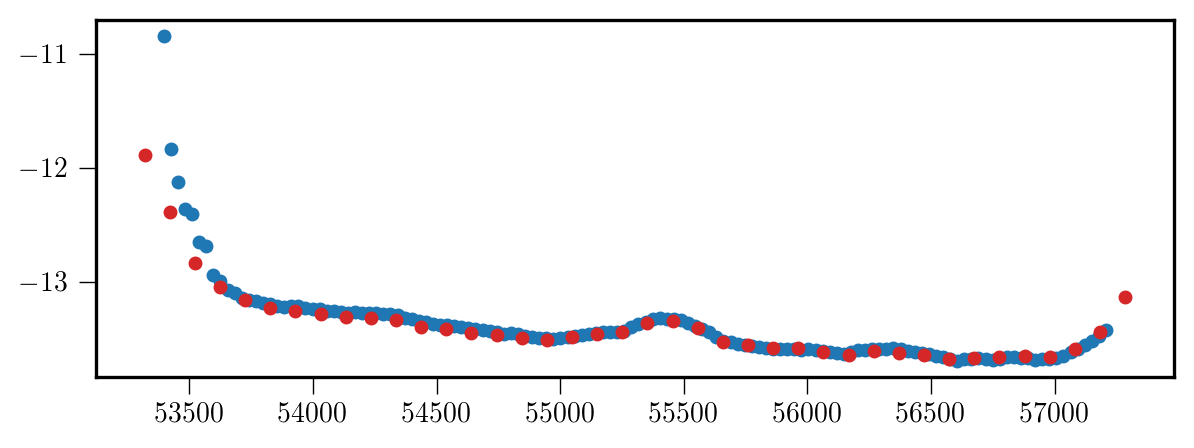

In [29]:
plt.show()